In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # on mac

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from utils.mag_scripts import * 
from utils.barplots import * 


import altair as alt


# supress warnings
import warnings
warnings.filterwarnings('ignore')

Differential abundance analysis based on genomes
================================================


## Load data

In [2]:
#go to output file 
%cd ../Example/

/Users/silas/Documents/GitHub/Tutorial/Example


In [3]:
# load metadata
metadata= pd.read_table('metadata.txt',index_col=0)
metadata.head()

,Age,Air_temperature,Diet,Food_name,Country,Provider,Sex,Strain,Body_weight
ERR675518,17.0,30.0,chow,D12450B,Norway,Taconic in Denmark,male,C57/BL6,25.62
ERR675519,17.0,30.0,HF,D12492,Norway,Taconic in Denmark,male,C57/BL6,30.15
ERR675520,17.0,30.0,chow,D12450B,Norway,Taconic in Denmark,male,C57/BL6,26.61
ERR675521,17.0,30.0,HF,D12492,Norway,Taconic in Denmark,male,C57/BL6,28.29
ERR675522,17.0,30.0,chow,D12450B,Norway,Taconic in Denmark,male,C57/BL6,26.49


In [4]:
#load counts

Counts= pd.read_csv('Results/counts/raw_counts_genomes.tsv',index_col=0,sep='\t').T
Counts.head()

Sample,MAG01,MAG02,MAG03,MAG04,MAG05,MAG06,MAG07,MAG08,MAG09,MAG10,...,MAG54,MAG55,MAG56,MAG57,MAG58,MAG59,MAG60,MAG61,MAG62,MAG63
ERR675518,17393,117204,240075,24199,97526,7149,6495,14480,4277446,1527105,...,837654,754481,222679,637364,2251197,13554,31078,598647,266917,50307
ERR675519,281563,34570,29109,726600,201572,842380,82081,899429,3267,158149,...,1032238,42293,63801,10632,2311946,219586,5,8844,380229,119444
ERR675520,26242,86293,109919,18037,104119,9283,14199,25,2791862,1290291,...,426057,758568,231036,281075,55038,13006,62974,8184,292100,105351
ERR675521,331737,36247,40084,747249,254551,936095,166398,572995,45186,186964,...,538591,83709,163914,13811,25583,194744,22,72826,283419,173115
ERR675522,23531,91372,35514,73140,36218,10569,5704,16,5908203,1051319,...,417819,530912,316013,15330,95070,28450,199,609486,158053,213068


In [5]:
# create a short label for each genome
Tax= pd.read_table('Results/taxonomy.tsv',index_col=0)
Labels=Tax.ffill(axis=1).species.copy()
Labels.loc[Tax.species.isnull()]+= ' '+ Labels.index[Tax.species.isnull()]


## Compositional data analysis 

There are good reasons to use rawcounts and use centric log ratios, see more on [Wikipedia] and  (https://en.wikipedia.org/wiki/Compositional_data) this article:

>Gloor, Gregory B., Jean M. Macklaim, Vera Pawlowsky-Glahn, and Juan J. Egozcue. 2017. “Microbiome Datasets Are  Compositional: And This Is Not Optional.” Frontiers in Microbiology 8 (November). Frontiers: 2224. 
    doi: [10.3389/fmicb.2017.02224](https://www.frontiersin.org/articles/10.3389/fmicb.2017.02224).




In [6]:
# transforme counts with centrig log ratio

data= clr(Counts)


### PCA (PCoA) of the robust aitchison distance

In [7]:

from sklearn.decomposition import PCA

pca= PCA()
transformed_data= pca.fit_transform(data)


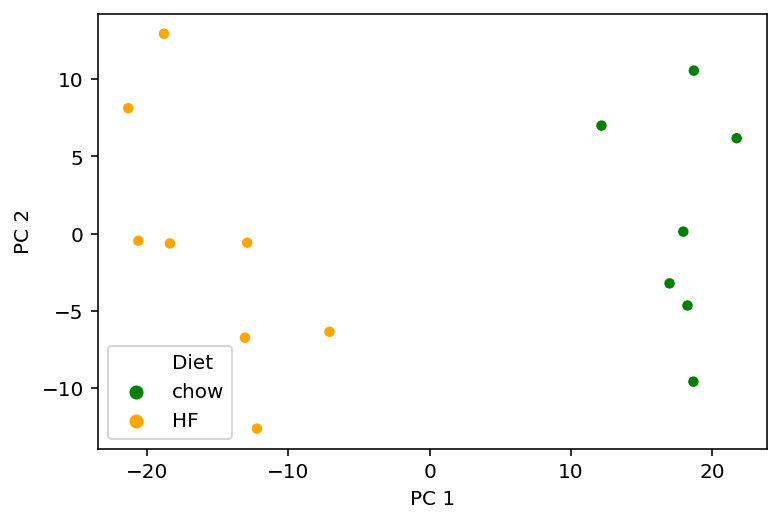

In [8]:
pca_data= pd.DataFrame()
pca_data['PC 1']= transformed_data[:,0]
pca_data['PC 2']= transformed_data[:,1]
pca_data.index= data.index


sns.set_palette(['green','orange'])
sns.scatterplot(x='PC 1',y='PC 2',data=pca_data,hue=metadata.Diet)




### Differencial abundance analyis

We use the welch test to asses differncial abundance in the two group. This is a simple version of aldex2. See Gloor et all for more information.


In [9]:


#man abundance per group
Stats= data.groupby(metadata.Diet).mean().T

#log Fold change. Ass the counts are normalized in centered log ratio the log FC becomes the difference
Stats['logFC']= Stats.HF-Stats.chow 

from scipy.stats import ttest_ind

_,p= ttest_ind(data.loc[ metadata.query('Diet=="HF"').index ],
          data.loc[ metadata.query('Diet=="chow"').index ],
          equal_var=False
         )

Stats['Pvalue']= p
Stats['logP']= -np.log10(Stats.Pvalue)
Stats['Name']= Labels


#### vulcano plot

In [10]:


xscale = alt.Scale(type='log')
alt.Chart(Stats).mark_circle(opacity= .6).encode(
    y='logP',
    x='logFC',
    color=alt.Color('logP',scale=alt.Scale(scheme='reds')),
    tooltip=['Name','HF','chow' ]
).interactive()


#non interactive plot
#sns.scatterplot(y='logP',x='logFC',data=Stats)

alt.Chart(...)

#### heatmap of significant Genomes

Correcting form multiple testing would be even better


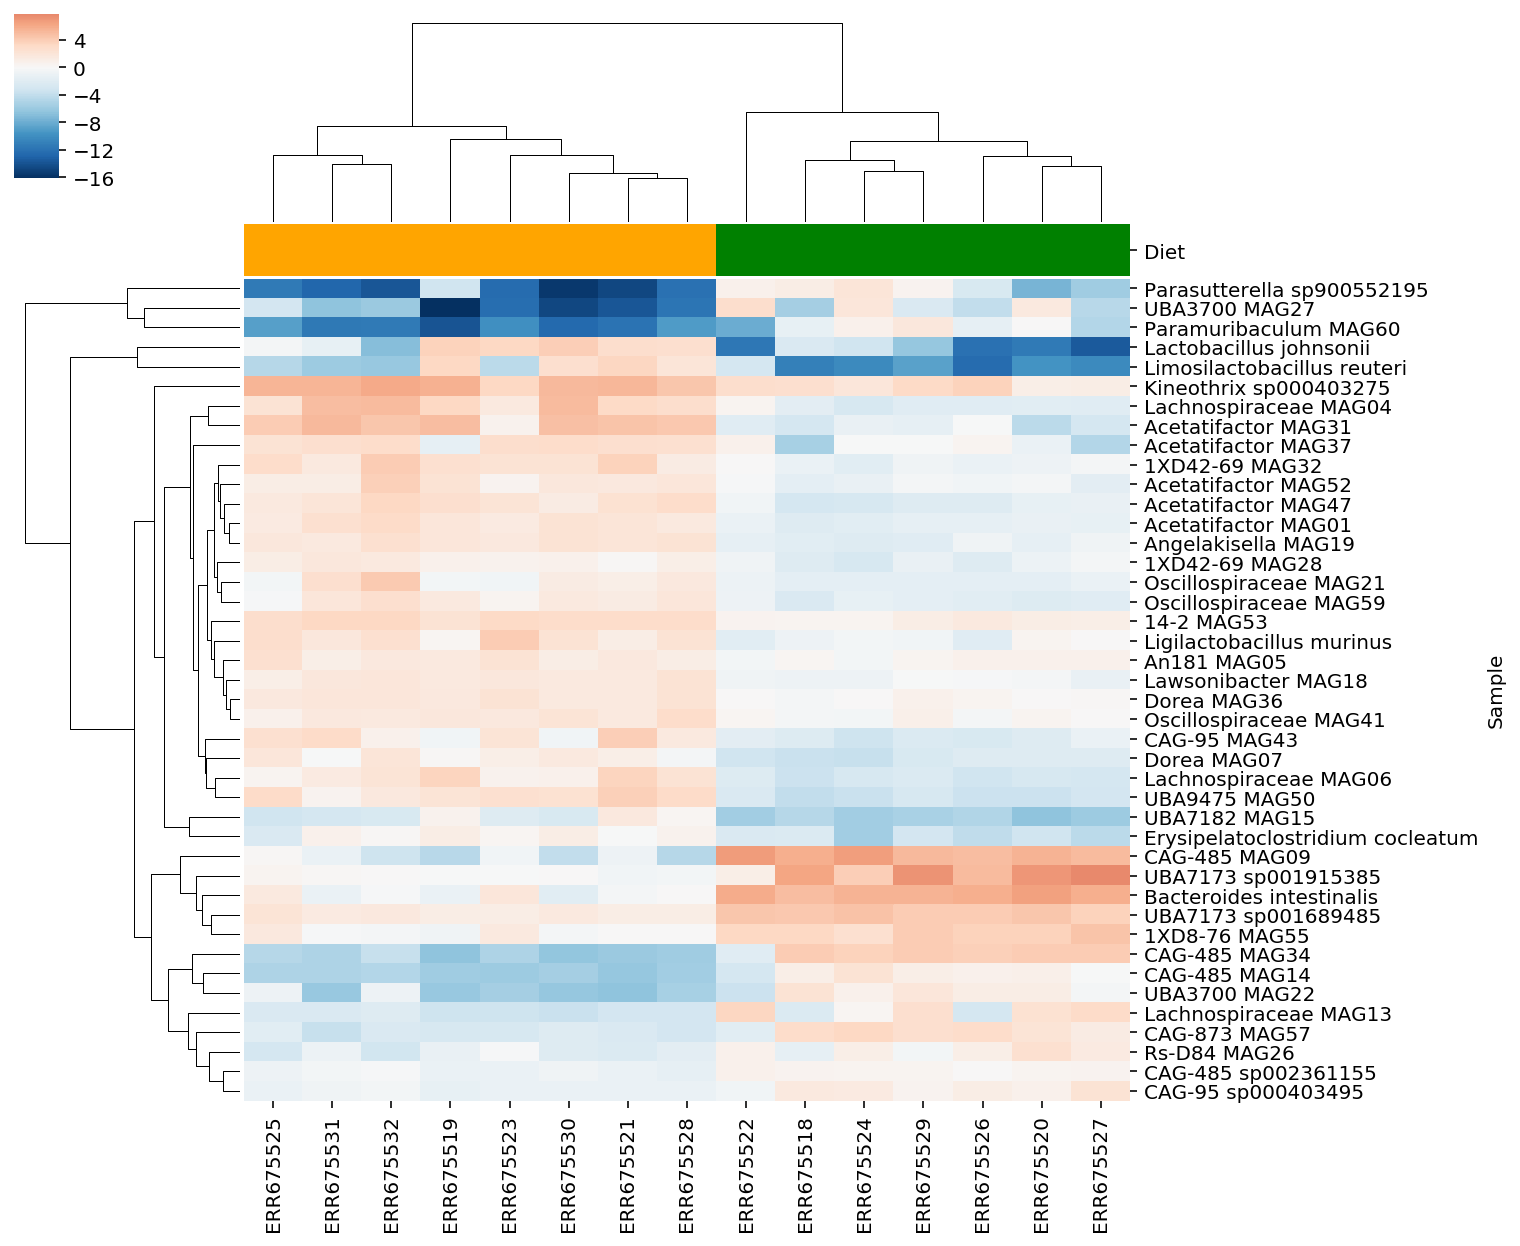

In [11]:
group_color=metadata.Diet.map({'HF':'orange','chow':'green'})

sig_data= data.T.loc[Stats.Pvalue<0.01]

sns.clustermap(sig_data,
            row_cluster=True,cmap='RdBu_r', center=0,
             yticklabels= Labels.loc[sig_data.index],
               col_colors= group_color
              )


## Relative abundance


For the relative abundance we take the coverage over the genome not the raw counts. This inmplicit normalizes for genome size. The coverage is calculated as the median of the coverage values calculated in 1kb blocks.

In [12]:
D = pd.read_table("Results/counts/median_coverage_genomes.tsv",index_col=0)

In [13]:
#calculate relative abundance

relab = (D.T/D.sum(1)).T

### Bar chart wich group labels

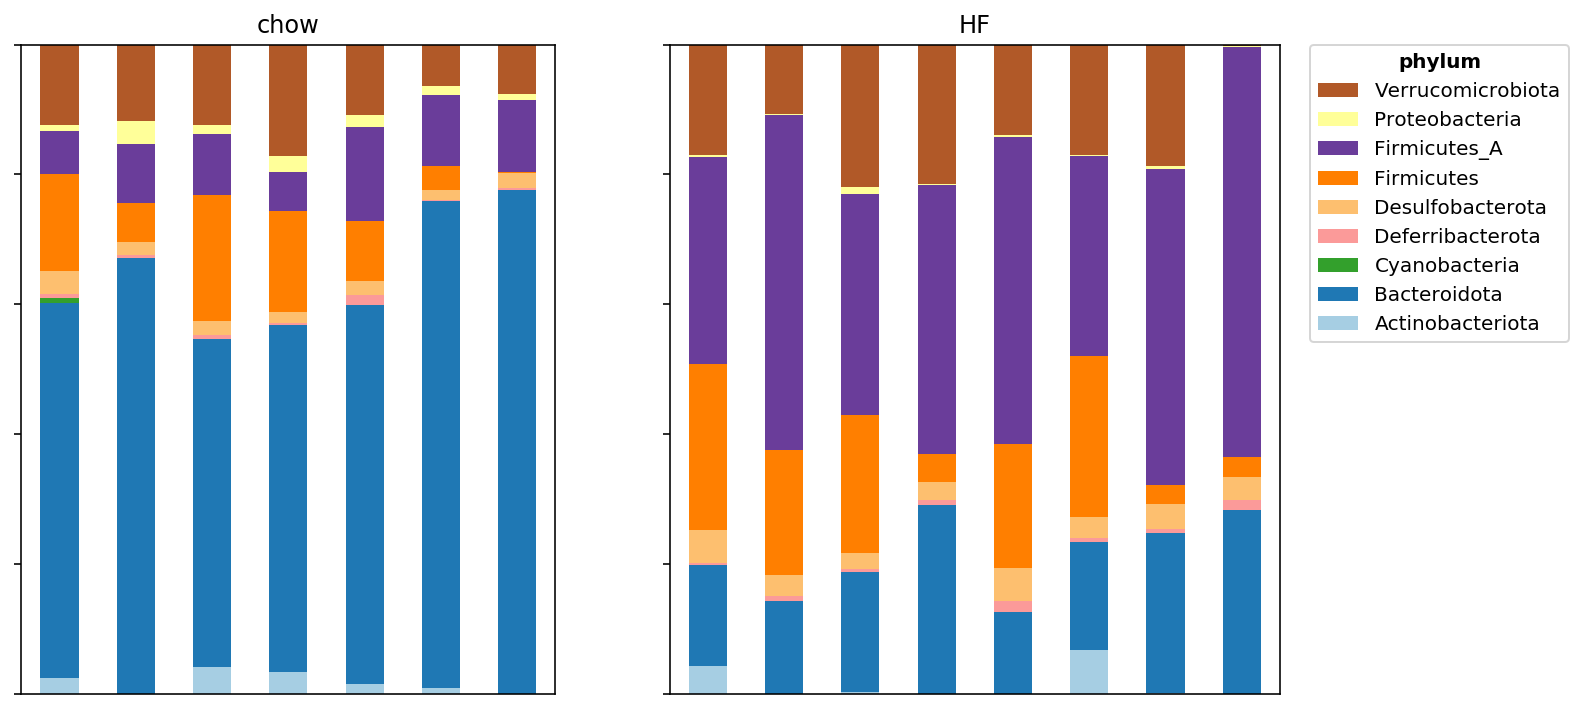

In [14]:

level='phylum'

grouped_data =relab.groupby(Tax[level],axis=1).sum()*100



axe=Grouped_Bar_Plot(grouped_data,metadata.Diet,figsize=(11,5),order=['chow','HF'])

axe[1].legend_.set_title(level,{'weight':'bold'})
